<a href="https://colab.research.google.com/github/Marciorochar/Analise-Preditiva/blob/main/Analises_Grafico_Regressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [447]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV
import warnings
warnings.filterwarnings('ignore')

In [448]:
# Carregar os dados
df = pd.read_excel("dados_completos_com_dummies_lags.xlsx", sheet_name="Modelo Completo", index_col=0)
df.index = pd.to_datetime(df.index)

In [449]:
# Selecionar lags e vari√°veis sazonais
lags = [f'lag_{i}' for i in range(1, 11)]
sazonais = [col for col in df.columns if 'dia_da_semana' in col or col in ['mes', 'feriado']]
X = df[lags + sazonais]
y = df['vendas']
X = sm.add_constant(X)
df_model = df.dropna(subset=lags + ['vendas'])

In [450]:
# Rolling OLS
def rolling_ols(y, X, janela=90):
    resultados = []
    for i in range(janela, len(X)):
        X_treino = X.iloc[i - janela:i]
        y_treino = y.iloc[i - janela:i]
        X_teste = X.iloc[i:i+1]
        modelo = sm.OLS(y_treino, X_treino).fit()
        y_pred = modelo.predict(X_teste)
        resultados.append({
            "data": y.index[i],
            "real": y.iloc[i],
            "previsto": y_pred.iloc[0],
            "res√≠duo": y.iloc[i] - y_pred.iloc[0],
            "r2": modelo.rsquared
        })
    return pd.DataFrame(resultados).set_index("data")

# Aplicar modelo
resultados = rolling_ols(y, X)
resultados.head()

real    previsto    res√≠duo        r2
data                                             
2022-04-16   120  111.951601   8.048399  0.383458
2022-04-17   109  107.371656   1.628344  0.401533
2022-04-18   106  102.006270   3.993730  0.426102
2022-04-19    89  105.832975 -16.832975  0.433153
2022-04-20   100  105.300245  -5.300245  0.423182

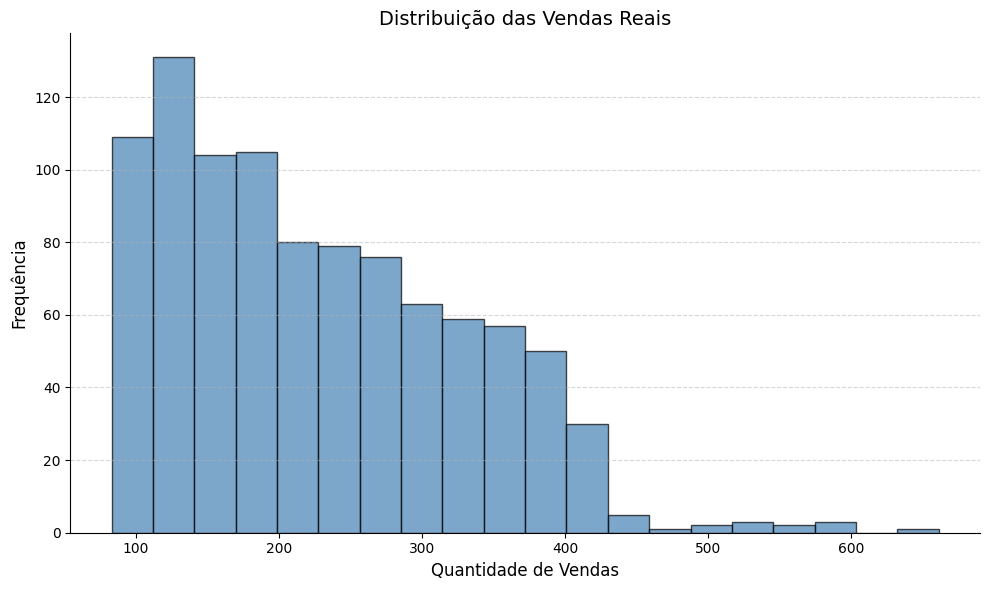

In [451]:
# @title Distribui√ß√£o das Vendas Reais

import matplotlib.pyplot as plt

# Plotar histograma das vendas reais
plt.figure(figsize=(10, 6))
plt.hist(resultados['real'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)

# T√≠tulos e r√≥tulos
plt.title('Distribui√ß√£o das Vendas Reais', fontsize=14)
plt.xlabel('Quantidade de Vendas', fontsize=12)
plt.ylabel('Frequ√™ncia', fontsize=12)

# Melhorar estilo do gr√°fico
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()


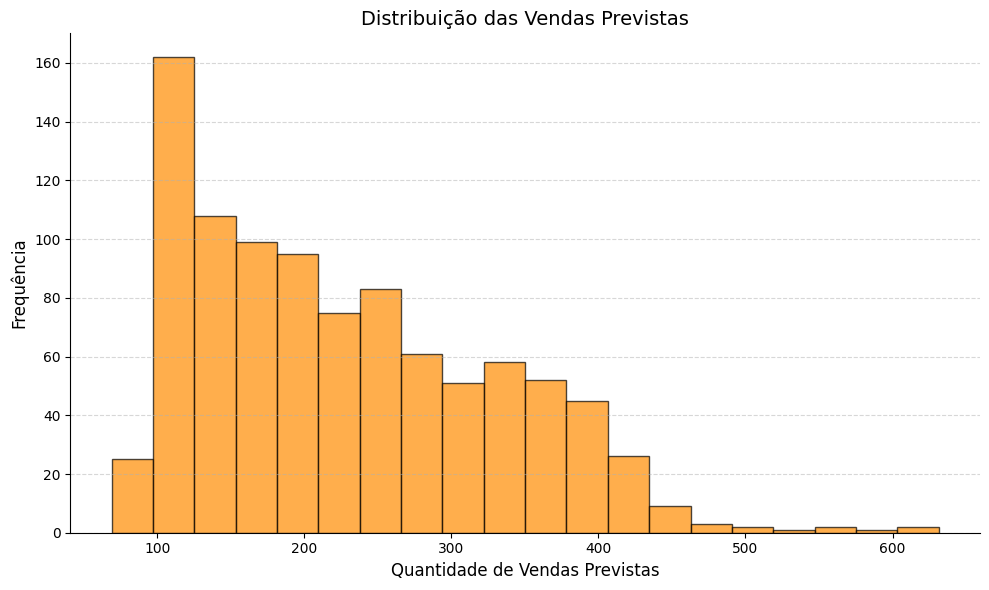

In [452]:
# @title Distribui√ß√£o das Vendas Previstas
# Plotar histograma das vendas previstas
plt.figure(figsize=(10, 6))
plt.hist(resultados['previsto'], bins=20, color='darkorange', edgecolor='black', alpha=0.7)

# T√≠tulos e r√≥tulos
plt.title('Distribui√ß√£o das Vendas Previstas', fontsize=14)
plt.xlabel('Quantidade de Vendas Previstas', fontsize=12)
plt.ylabel('Frequ√™ncia', fontsize=12)

# Melhorar estilo do gr√°fico
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()

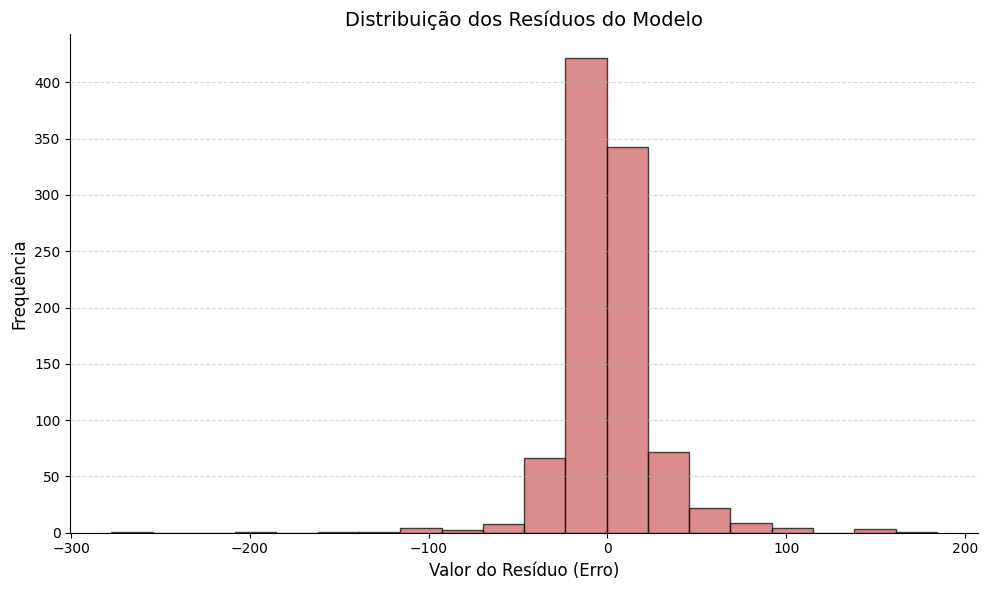

In [453]:
# @title Histograma dos Res√≠duos

# Plotar histograma dos res√≠duos
plt.figure(figsize=(10, 6))
plt.hist(resultados['res√≠duo'], bins=20, color='indianred', edgecolor='black', alpha=0.7)

# T√≠tulos e r√≥tulos
plt.title('Distribui√ß√£o dos Res√≠duos do Modelo', fontsize=14)
plt.xlabel('Valor do Res√≠duo (Erro)', fontsize=12)
plt.ylabel('Frequ√™ncia', fontsize=12)

# Melhorar estilo do gr√°fico
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()

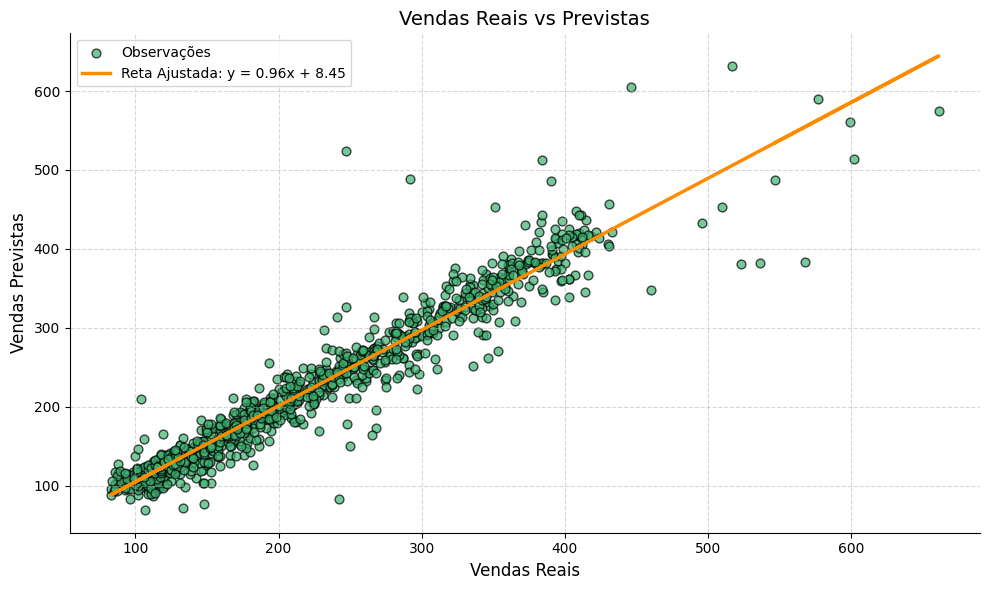

In [454]:
# @title real vs previsto

x = resultados['real']
y = resultados['previsto']

# Ajuste de regress√£o linear: y = a*x + b
a, b = np.polyfit(x, y, 1)
reta_ajustada = a * x + b

# Gr√°fico de dispers√£o com reta ajustada
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=40, alpha=0.7, color='mediumseagreen', edgecolor='black', label='Observa√ß√µes')
plt.plot(x, reta_ajustada, color='darkorange', linewidth=2.5, label=f'Reta Ajustada: y = {a:.2f}x + {b:.2f}')

# Est√©tica
plt.title('Vendas Reais vs Previstas', fontsize=14)
plt.xlabel('Vendas Reais', fontsize=12)
plt.ylabel('Vendas Previstas', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

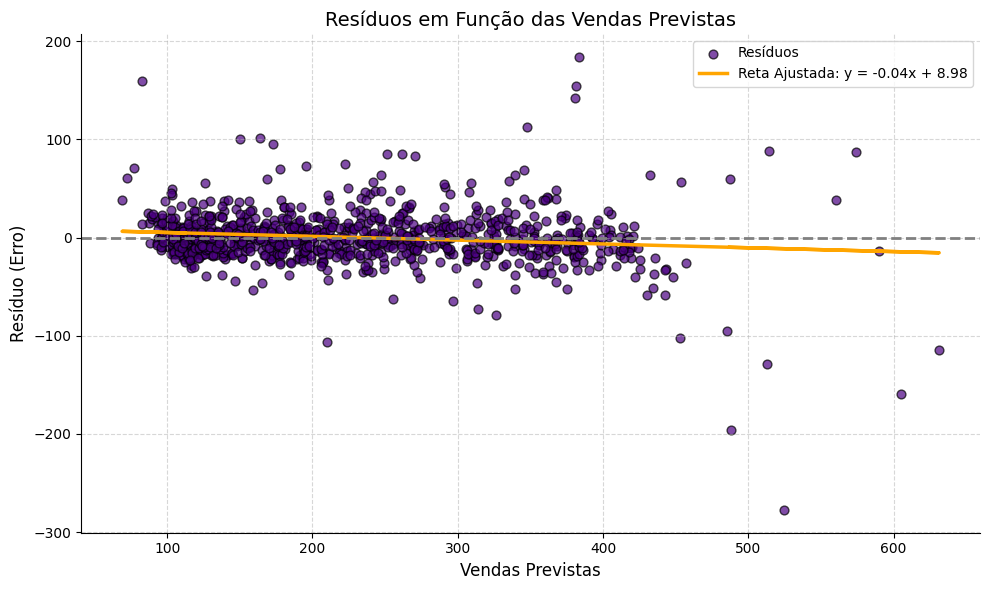

In [455]:
# @title previsto vs res√≠duo

# Dados
x = resultados['previsto']
y = resultados['res√≠duo']

# Ajuste de reta (regress√£o linear): y = a*x + b
a, b = np.polyfit(x, y, 1)
reta_ajustada = a * x + b

# Plotagem
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=40, alpha=0.7, color='indigo', edgecolor='black', label='Res√≠duos')
plt.plot(x, reta_ajustada, color='orange', linewidth=2.5, label=f'Reta Ajustada: y = {a:.2f}x + {b:.2f}')

# Linha de refer√™ncia y = 0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)

# Est√©tica e r√≥tulos
plt.title('Res√≠duos em Fun√ß√£o das Vendas Previstas', fontsize=14)
plt.xlabel('Vendas Previstas', fontsize=12)
plt.ylabel('Res√≠duo (Erro)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

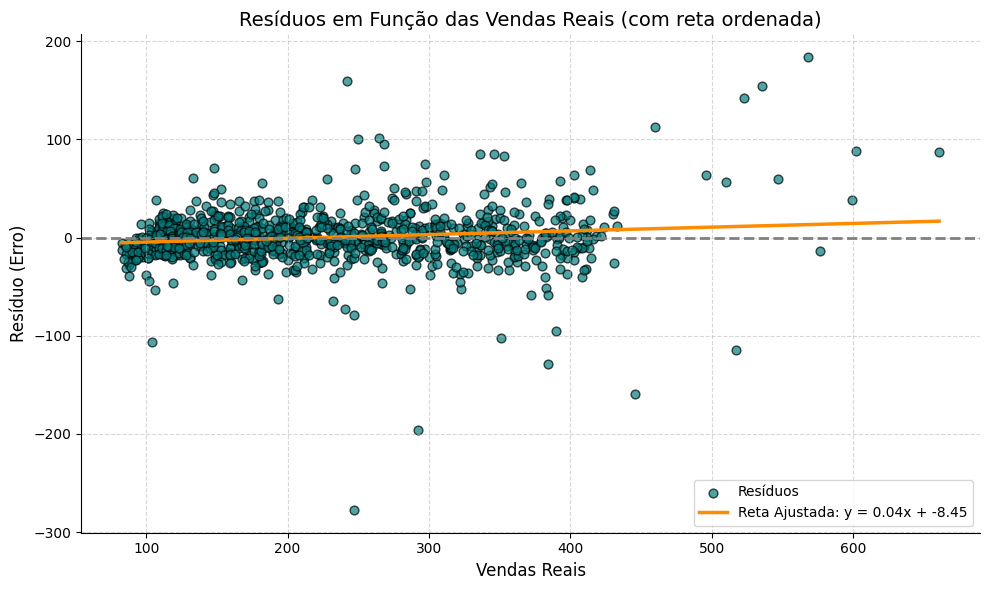

In [456]:
# @title res√≠duo vs r2


x = resultados['real']
y = resultados['res√≠duo']

# Regress√£o linear: reta ajustada
a, b = np.polyfit(x, y, 1)
reta = a * x + b

# Ordenar para reta cont√≠nua
ordem = np.argsort(x)
x_ord = x.iloc[ordem]
reta_ord = reta.iloc[ordem]

# Plotagem
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=40, alpha=0.7, color='teal', edgecolor='black', label='Res√≠duos')
plt.plot(x_ord, reta_ord, color='darkorange', linewidth=2.5, label=f'Reta Ajustada: y = {a:.2f}x + {b:.2f}')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)

# Est√©tica
plt.title('Res√≠duos em Fun√ß√£o das Vendas Reais (com reta ordenada)', fontsize=14)
plt.xlabel('Vendas Reais', fontsize=12)
plt.ylabel('Res√≠duo (Erro)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

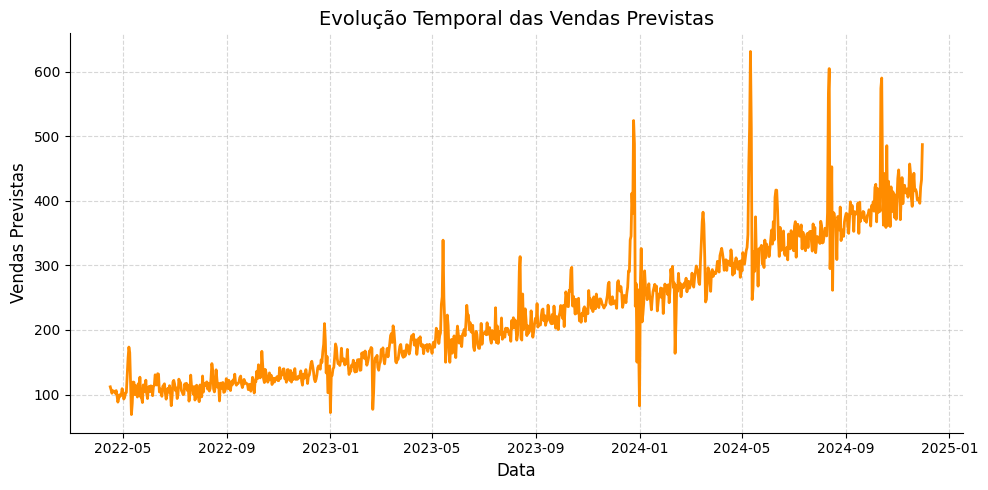

In [457]:
# @title previsto

# Plotar s√©rie temporal das previs√µes
plt.figure(figsize=(10, 5))
plt.plot(resultados.index, resultados['previsto'], color='darkorange', linewidth=2)

# T√≠tulo e r√≥tulos
plt.title('Evolu√ß√£o Temporal das Vendas Previstas', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Vendas Previstas', fontsize=12)

# Est√©tica
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

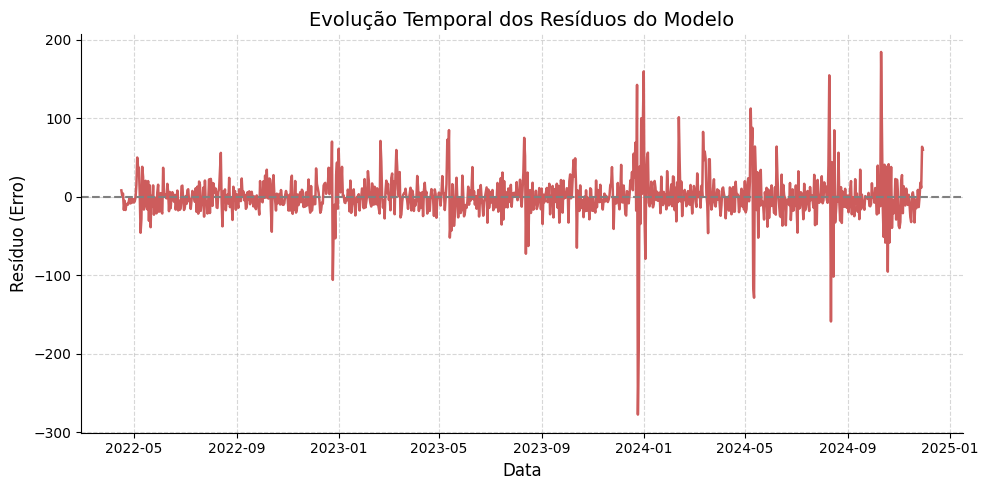

In [458]:
# @title res√≠duo

# Plotar s√©rie temporal dos res√≠duos
plt.figure(figsize=(10, 5))
plt.plot(resultados.index, resultados['res√≠duo'], color='indianred', linewidth=1.8)

# Linha horizontal de refer√™ncia (res√≠duo = 0)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)

# T√≠tulo e r√≥tulos
plt.title('Evolu√ß√£o Temporal dos Res√≠duos do Modelo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Res√≠duo (Erro)', fontsize=12)

# Est√©tica
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

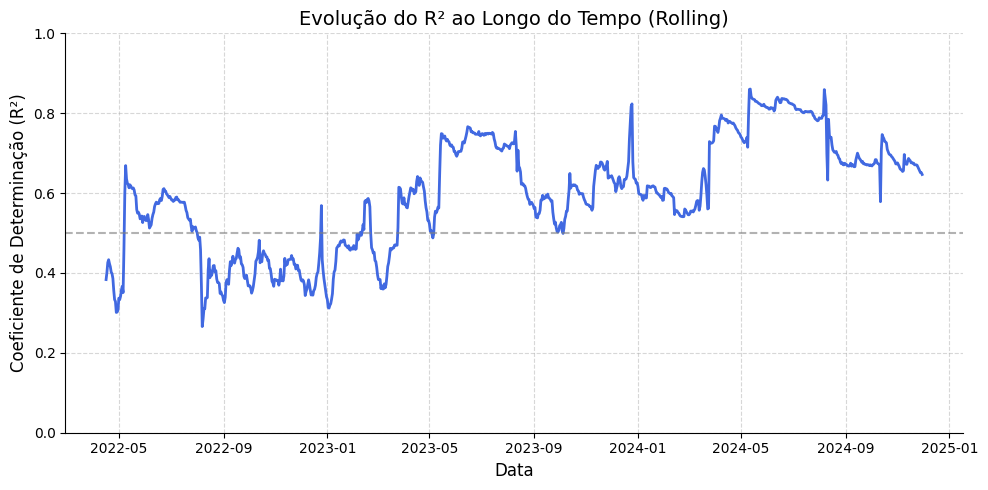

In [459]:
# @title S√©rie temporal do R¬≤

# Plotar s√©rie temporal do R¬≤
plt.figure(figsize=(10, 5))
plt.plot(resultados.index, resultados['r2'], color='royalblue', linewidth=2)

# T√≠tulo e r√≥tulos
plt.title('Evolu√ß√£o do R¬≤ ao Longo do Tempo (Rolling)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Coeficiente de Determina√ß√£o (R¬≤)', fontsize=12)

# Linha de refer√™ncia em R¬≤ = 0.5 (opcional, ponto cr√≠tico)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.6)

# Est√©tica
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)  # Mant√©m a escala entre 0 e 1 (v√°lido para R¬≤)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

In [460]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular m√©tricas de desempenho
rmse = np.sqrt(mean_squared_error(resultados['real'], resultados['previsto']))
mae = mean_absolute_error(resultados['real'], resultados['previsto'])
r2_medio = resultados['r2'].mean()

# Exibir resultados formatados
print(f"üîπ RMSE (Raiz do Erro Quadr√°tico M√©dio): {rmse:.2f}")
print(f"üîπ MAE (Erro Absoluto M√©dio): {mae:.2f}")
print(f"üîπ R¬≤ m√©dio (coeficiente de determina√ß√£o): {r2_medio:.4f}")

üîπ RMSE (Raiz do Erro Quadr√°tico M√©dio): 28.03
üîπ MAE (Erro Absoluto M√©dio): 17.16
üîπ R¬≤ m√©dio (coeficiente de determina√ß√£o): 0.5961


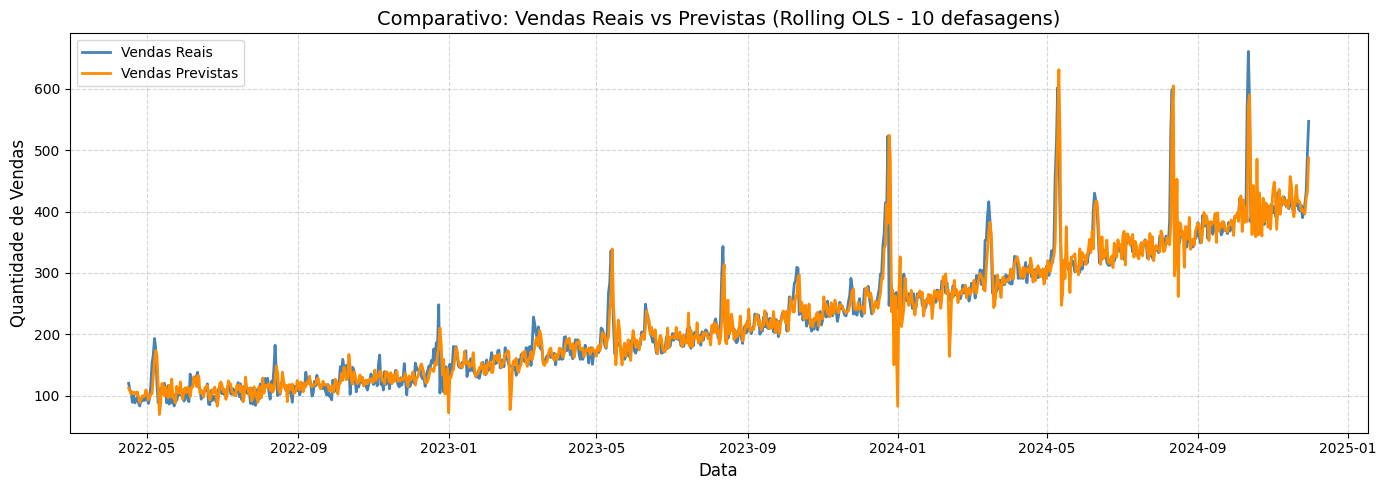

In [461]:
# @title Gr√°fico de linha: real vs previsto
# Gr√°fico de linha: real vs previsto
plt.figure(figsize=(14, 5))
plt.plot(resultados.index, resultados['real'], label='Vendas Reais', linewidth=2, color='steelblue')
plt.plot(resultados.index, resultados['previsto'], label='Vendas Previstas', linewidth=2, color='darkorange')

# T√≠tulo e r√≥tulos
plt.title('Comparativo: Vendas Reais vs Previstas (Rolling OLS - 10 defasagens)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Quantidade de Vendas', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

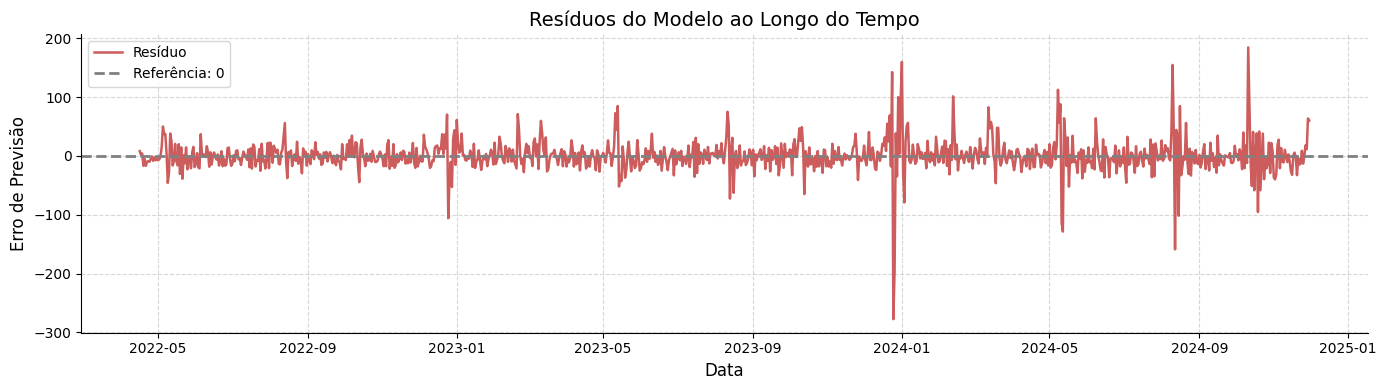

In [462]:
# @title Res√≠duos do Modelo ao Longo do Tempo


plt.figure(figsize=(14, 4))
plt.plot(resultados.index, resultados['res√≠duo'], color='indianred', linewidth=1.8, label='Res√≠duo')
plt.axhline(0, color='gray', linestyle='--', linewidth=2, label='Refer√™ncia: 0')

# T√≠tulo e r√≥tulos
plt.title('Res√≠duos do Modelo ao Longo do Tempo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Erro de Previs√£o', fontsize=12)

# Est√©tica
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()


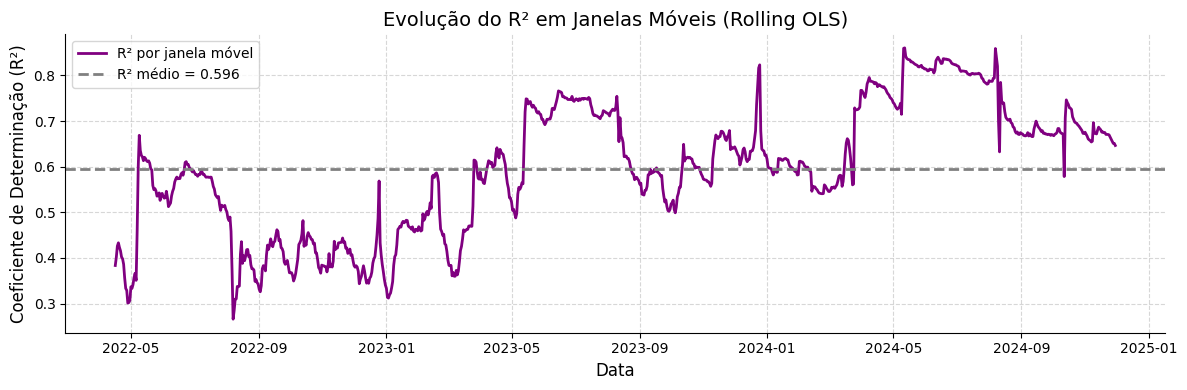

In [463]:

plt.figure(figsize=(12, 4))
plt.plot(resultados.index, resultados['r2'], color='purple', linewidth=2, label='R¬≤ por janela m√≥vel')
plt.axhline(resultados['r2'].mean(), color='gray', linestyle='--', linewidth=2, label=f'R¬≤ m√©dio = {resultados["r2"].mean():.3f}')

# T√≠tulo e r√≥tulos
plt.title('Evolu√ß√£o do R¬≤ em Janelas M√≥veis (Rolling OLS)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Coeficiente de Determina√ß√£o (R¬≤)', fontsize=12)

# Est√©tica
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

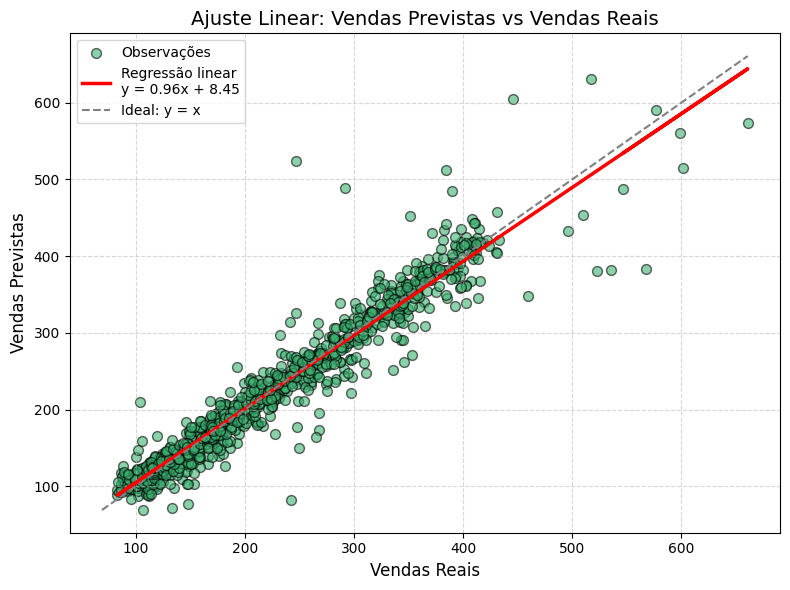

In [464]:

from scipy.stats import linregress
import matplotlib.pyplot as plt

# Definir vari√°veis
x = resultados['real']
y_ = resultados['previsto']

# Regress√£o linear
slope, intercept, r_value, p_value, std_err = linregress(x, y_)
linha_reg = slope * x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y_, alpha=0.6, s=50, edgecolor='black', color='mediumseagreen', label='Observa√ß√µes')
plt.plot(x, linha_reg, color='red', linewidth=2.5, label=f'Regress√£o linear\ny = {slope:.2f}x + {intercept:.2f}')

# Linha ideal
limite_min = min(x.min(), y_.min())
limite_max = max(x.max(), y_.max())
plt.plot([limite_min, limite_max], [limite_min, limite_max], color='gray', linestyle='--', label='Ideal: y = x')

# Est√©tica
plt.xlabel('Vendas Reais', fontsize=12)
plt.ylabel('Vendas Previstas', fontsize=12)
plt.title('Ajuste Linear: Vendas Previstas vs Vendas Reais', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [465]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
from datetime import datetime
import statsmodels.api as sm

# 1. Definir feriados nacionais fixos
class FeriadosBrasil(AbstractHolidayCalendar):
    rules = [
        Holiday('Ano Novo', month=1, day=1),
        Holiday('Tiradentes', month=4, day=21),
        Holiday('Dia do Trabalho', month=5, day=1),
        Holiday('Independ√™ncia', month=9, day=7),
        Holiday('Nossa Senhora Aparecida', month=10, day=12),
        Holiday('Finados', month=11, day=2),
        Holiday('Proclama√ß√£o da Rep√∫blica', month=11, day=15),
        Holiday('Natal', month=12, day=25)
    ]

# 2. Gerar os feriados entre 2022 e 2024
feriados = FeriadosBrasil().holidays(start='2022-01-01', end='2024-12-31')

# 3. Prever para a data futura
data_futura = datetime(2024, 12, 1)
X_futuro = X.iloc[-1:].copy()  # base de estrutura

# 4. Atualizar lags com √∫ltimos valores reais de vendas
for i in range(1, 11):
    X_futuro[f'lag_{i}'] = df['vendas'].iloc[-i]

# 5. Atualizar vari√°veis sazonais
X_futuro['mes'] = data_futura.month
X_futuro['feriado'] = int(data_futura in feriados)

# 6. Atualizar dummies de dia da semana
for d in range(1, 7):  # assumindo dummies com drop_first=True
    X_futuro[f'dia_da_semana_{d}'] = int(data_futura.weekday() == d)

# 7. Reindexar para garantir as mesmas colunas que o modelo usou
X_futuro = sm.add_constant(X_futuro.reindex(columns=X.columns, fill_value=0))

# 8. Previs√£o final
previsao = modelo_final.predict(X_futuro)
print(f"üìà Previs√£o de vendas para {data_futura.strftime('%d/%m/%Y')}: {previsao.iloc[0]:.2f} unidades")




üìà Previs√£o de vendas para 01/12/2024: 524.07 unidades
